In [51]:
#ipython magic function to render matplotlib plots in the notebook
%matplotlib inline  
import os
import matplotlib.pyplot as plt #plotting
import numpy as np #scientific computing for python
import rasterio #access to raster data wrapping GDAL
from rasterio.windows import Window
from rasterstats import zonal_stats #zonal stats plugin for rasterio
import fiona #access to vector data wrapping OGR
from shapely.geometry import shape #shapely Py geospatial geometry manip library


In [52]:
def fetch_ground_truth_polygon(id='NT/70348/31743'):
    """
    use fiona to grab a polygon geometry with the given id
    from the V5+2018_Inspection_Kelso.shp shapefile
    
    :param id: the FID_1 code of the feature to return from the V5+2018_Inspection_Kelso.shp shapefile  
    :return: a Shapely polygon geometry
    """
    poly_geom = None
    
    if os.path.exists("/home/james/serviceDelivery/CropMaps/GroundTruth/Ground_Truth_V5+2018_Inspection/V5+2018_Inspection_Kelso.shp"):
        with fiona.open("/home/james/serviceDelivery/CropMaps/GroundTruth/Ground_Truth_V5+2018_Inspection/V5+2018_Inspection_Kelso.shp", "r") as src:
            for f in src:
                if f["properties"]["FID_1"] == id:
                    poly_geom = shape(f["geometry"])
        
    return poly_geom

def fetch_window_from_raster(fname, aoi_geo_min_x, aoi_geo_min_y, aoi_geo_max_x, aoi_geo_max_y, band=1, dbg=False):
    """
    use rasterio to fetch a sub-window from a raster
    
    :param fname: the raster to fetch from 
    :param aoi_geo_min_x: llx of sub-window to fetch
    :param aoi_geo_min_y: lly of sub-window to fetch
    :param aoi_geo_max_x: urx of sub-window to fetch
    :param aoi_geo_max_y: ury of sub-window to fetch
    :param band: band to fetch from the raster
    :param dbg: print debug messages
    :return: the sub-region as a NumPy ndarray, the affine tranformation matrix for the sub-window
    """

    the_window = None
    with rasterio.open(fname) as src:
        w = src.width
        h = src.height
        max_row = h #y
        max_col = w #x
        
        if dbg:
            print("Width: {}".format(w))
            print("Height: {}".format(h))
        
        # get transform for whole image that maps pixel (row,col) location to geospatial (x,y) location
        affine = src.transform
        
        if dbg: 
            print(rasterio.transform.xy(affine, rows=[0, max_row], cols=[0, max_col]))

        rows, cols = rasterio.transform.rowcol(affine, xs=[aoi_geo_min_x, aoi_geo_max_x], ys=[aoi_geo_min_y, aoi_geo_max_y])
        
        aoi_img_min_col = cols[0]
        aoi_img_min_row = rows[0]
        aoi_img_max_col = cols[1]
        aoi_img_max_row = rows[1]
        
        if dbg:
            print(aoi_img_min_col, aoi_img_min_row, aoi_img_max_col, aoi_img_max_row)
        
        aoi_width = aoi_img_max_col - aoi_img_min_col
        aoi_height = aoi_img_min_row - aoi_img_max_row
        
        if dbg:
            print(aoi_width, aoi_height)
        
        # just read a window from the complete image
        # rasterio.windows.Window(col_off, row_off, width, height)
        this_window = Window(aoi_img_min_col, aoi_img_min_row-aoi_height, aoi_width, aoi_height)
        the_window = src.read(band, window=this_window)
        #print(affine)

        # the affine transformation of a window differs from the entire image
        # https://github.com/mapbox/rasterio/blob/master/docs/topics/windowed-rw.rst
        # so get transform just for the window that maps pixel (row, col) location to geospatial (x,y) location
        win_affine = src.window_transform(this_window)
        #print(win_affine)
        
        affine = win_affine
        
    # return the window (NumPy) array and the transformation matrix for the window providing img->geo location
    return the_window, affine

        

In [53]:
this_fname = "/home/james/serviceDelivery/CropMaps/JNCCSupply010519/S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif"

# the coordinates of the extent of the training data obtained using
#    SELECT st_xmin(ss.geom), st_ymin(ss.geom), st_xmax(ss.geom), st_ymax(ss.geom)
#    FROM (
#          SELECT st_buffer(st_envelope(st_collect(s.geom)), 100) as geom
#          FROM (
#                  SELECT geom
#                  FROM geocrud.master_land_cover_results_v6_analysis
#              ) s
#     ) ss

this_aoi_geo_min_x = 363645.98 
this_aoi_geo_min_y = 619078.236  
this_aoi_geo_max_x = 380358.43
this_aoi_geo_max_y = 636682.04

this_aoi = None
this_affine = None

# fetch a sub-window of raster data from the complete image that fall within the extent of the training data
# my_aoi is a NumPy ndarray of data
# aoi_affine is a transformation matrix than provides a transform for the window from img->geo coord space
this_aoi, this_affine = fetch_window_from_raster(
    this_fname,
    this_aoi_geo_min_x,
    this_aoi_geo_min_y,
    this_aoi_geo_max_x,
    this_aoi_geo_max_y,
    band=1,
    dbg=False
)


Extract an AOI from the complete image bounded to envelope of training data
<class 'numpy.ndarray'>
Some NumPy stats for the AOI
aoi (NumPy ndarray size): 2940960
aoi (NumPy ndarray min): -26.790613
aoi (NumPy ndarray max): 15.162444
aoi (NumPy ndarray mean): -10.990629
The affine transformation from geo to img space:
affine | 10.00, 0.00, 363640.60|
| 0.00,-10.00, 636686.20|
| 0.00, 0.00, 1.00|


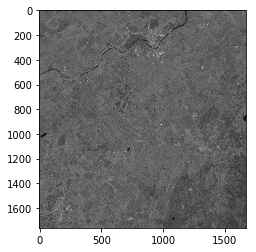

In [54]:
# use NumPy to show stats related to this part of the image
print("Extract an AOI from the complete image bounded to envelope of training data")
print(type(this_aoi))
# stats provided by NumPy itself for the entire AOI
print("Some NumPy stats for the AOI")
print("aoi (NumPy ndarray size):", this_aoi.size)
print("aoi (NumPy ndarray min):", np.amin(this_aoi))
print("aoi (NumPy ndarray max):", np.amax(this_aoi))
print("aoi (NumPy ndarray mean):", np.mean(this_aoi))
plt.imshow(this_aoi, cmap="gray")
print("The affine transformation from geo to img space:")
print("affine", this_affine)


In [60]:
# Fetch a ground truth polygon geometry
print("Fetch ground truth polygon")
gt_id='NT/70348/31743'
gt_poly = fetch_ground_truth_polygon(id=gt_id)

# show the coordinates of our AOI and the centroid of the ground truth polygon
print("aoi_coords:", this_aoi_geo_min_x, this_aoi_geo_min_y, this_aoi_geo_max_x, this_aoi_geo_max_y)
print("gt_poly_centroid", gt_poly.centroid)
print(gt_poly.bounds)


Fetch ground truth polygon
aoi_coords: 363645.98 619078.236 380358.43 636682.04
gt_poly_centroid POINT (370356.3102939065 631760.3091407312)
(370169.04, 631545.6, 370554.15, 631968.31)


In [59]:
# use the rasterstats rasterio plugin to calculate zonal stats for the ground truth polygon
print("Zonal stats from rasterio rasterstats")
zs = zonal_stats(
    gt_poly,
    this_aoi,
    affine=this_affine, #affine needed as we are passing in an ndarray
    stats=["count", "min", "max", "mean", "median", "std", "range"], #zonal stats we want
    all_touched=False #include every cell touched by geom or only cells with center within geom 
)
print("zonal stats:", zs)


Zonal stats from rasterio rasterstats
zonal stats: [{'max': -7.781466960906982, 'min': -15.22705364227295, 'std': 1.1541396850228278, 'range': 7.445586681365967, 'mean': -11.695837397224624, 'median': -11.765733242034912, 'count': 1006}]


/home/james/py3dev/lib/python3.5/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
